# Aunalytics Data Science Exercise

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split,RandomizedSearchCV,validation_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold,GridSearchCV
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve,roc_auc_score,f1_score
import warnings
warnings.simplefilter('ignore')

Using TensorFlow backend.


# 1. Importing data sets

In [2]:
train = pd.read_csv('au_train.csv',sep =',')
test =  pd.read_csv('au_test.csv',sep = ',')

# 2. Training data preparation

Here we explore the data set for any changes/imputations to be made. Please refer to the segmentation study for futher details on these steps.

Encoding of response variable is done

Data types of variables are set to appropriate ones

Missing values are imputed



In [3]:
#Encoding the response variable to 0 and 1
train = train.sample(frac=1).reset_index(drop=True)
train['income'] = 0
train['income'][train['class'] == ' <=50K'] = 0
train['income'][train['class'] == ' >50K'] = 1

train = train.drop(['class'],axis = 1)


In [ ]:
train.head()

In [4]:
#Changing data types
train[['workclass', 'education','marital-status','occupation','relationship','race','sex','native-country']] = train[['workclass', 'education','marital-status','occupation','relationship','race','sex','native-country']].astype('category') 
print(train.dtypes)
#Replacing ? with NULL
train.replace(' ?', np.nan, inplace= True)
train.isnull().sum(axis=0)

age                  int64
workclass         category
fnlwgt               int64
education         category
education-num        int64
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain         int64
capital-loss         int64
hours-per-week       int64
native-country    category
income               int64
dtype: object


age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

In [5]:
#Imputing NULL values by adding new categories
train['workclass'] = train['workclass'].cat.add_categories('None')
train['workclass'].fillna('None', inplace =True) 
train['occupation'] = train['occupation'].cat.add_categories('Unemployed')
train['occupation'].fillna('Unemployed', inplace =True) 
train['native-country'] = train['native-country'].cat.add_categories('Unknown')
train['native-country'].fillna('Unknown', inplace =True)

## 2.1. One-Hot Encoding For Categorical Values

In [6]:
X = train.loc[:, train.columns != 'income']
Y = train['income']
Y = Y.astype('category')
label = LabelEncoder()
X = X.drop(columns = ['native-country'],axis = 1) #Dropping 'native-country'
X_enc = X.select_dtypes(include = ['category'])
X_enc = pd.get_dummies(X_enc,columns = ['workclass','education','marital-status','occupation','relationship',
                                       'race','sex'])
X_copy = X.drop(columns = ['workclass','education','marital-status','occupation','relationship',
                                       'race','sex'],axis = 1)
X_enc = X_enc.apply(label.fit_transform)
X_final = pd.concat([X_copy,X_enc],axis = 1)

In [ ]:
#X.info()

## 2.2. Splitting dataset into Training and Validation data sets

Training data: 70%
    
Validation data: 30%

In [7]:
np.random.seed(123)
X_train, X_val, Y_train, Y_val = train_test_split(X_final,Y,test_size = 0.3,stratify = Y)

In [8]:
# Creating a function to plot ROC curve 
def plot_roc_curve(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

# 3. Modeling

Models used are Logistic regression, KNN, support vector classifier, random forests, gradient boosting, naive bayes, extreme gradient boosting.

Hyperparameters are tuned for all the models, though, cross-validation was not used for hyperparameter tuning apart from logistic regression because of lack of computing power.

### Model - 1 : Logistic Regression

In [ ]:
#Hyperparameter tuning
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [9]:
#Using best model
lr = LogisticRegression(C=1,penalty='l2')
lr.fit(X_train,Y_train)

print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(lr.score(X_train, Y_train)))
print('Accuracy of Logistic regression classifier on validation set: {:.2f}'
     .format(lr.score(X_val, Y_val)))

Accuracy of Logistic regression classifier on training set: 0.80
Accuracy of Logistic regression classifier on validation set: 0.80


In [10]:
lr_acc = round((lr.score(X_val, Y_val)),2)
print(lr_acc)

0.8


In [11]:
#Performance metrics
probs_lr = lr.predict_proba(X_val)  
probs_lr = probs_lr[:, 1]  
fper, tper, thresholds = roc_curve(Y_val, probs_lr) 
#plot_roc_curve(fper, tper)
auc_lr = roc_auc_score(Y_val, probs_lr)
print('AUC for logistic regression: %.2f' % auc_lr)
y_pred = lr.predict(X_val)
f1_lr = f1_score(y_pred, Y_val)
print('F1 score for logistic regrssion: %.2f' % f1_lr)

AUC for logistic regression: 0.57
F1 score for logistic regrssion: 0.38


### Model - 2 : K-Nearest Neighbours

In [12]:
#Applying model with default parameters
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, Y_train)))
print('Accuracy of K-NN classifier on validation set: {:.2f}'
     .format(knn.score(X_val, Y_val)))

Accuracy of K-NN classifier on training set: 0.83
Accuracy of K-NN classifier on validation set: 0.78


In [13]:
knn_acc = round((knn.score(X_val, Y_val)),2)
print(knn_acc)

0.78


In [14]:
#Performance metrics
probs_knn = knn.predict_proba(X_val)  
probs_knn = probs_knn[:, 1]  
fper, tper, thresholds = roc_curve(Y_val, probs_knn) 
#plot_roc_curve(fper, tper)
auc_knn = roc_auc_score(Y_val, probs_knn)
print('AUC for KNN: %.2f' % auc_knn)
y_pred = knn.predict(X_val)
f1_knn = f1_score(y_pred, Y_val)
print('F1 score for KNN: %.2f' % f1_knn)

AUC for KNN: 0.67
F1 score for KNN: 0.40


### Model - 3 : Random Forest

Learning curve for number of trees was plotted to check for optimal number of trees

In [ ]:
#Hyperparameter tuning
num_est = [10,50,100,500]
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = Y_train, 
                                param_name = 'n_estimators', 
                                param_range = num_est, cv = 3)
param_range = [10,50,100,500]
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)

test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)

plt.plot(num_est, train_mean, label="Training score", color="black")
plt.plot(num_est, test_mean, label="Testing score", color="dimgrey")
plt.fill_between(num_est, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(num_est, test_mean - test_std, test_mean + test_std, color="gainsboro")
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

The learning curve flattens pretty much after 50 trees, so we proceed with 50 trees

In [15]:
#Applying best model
rf = RandomForestClassifier(n_estimators = 50)
rf.fit(X_train, Y_train)

print('Accuracy of Random Forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, Y_train)))
print('Accuracy of Random Forest classifier on validation set: {:.2f}'
     .format(rf.score(X_val, Y_val)))

Accuracy of Random Forest classifier on training set: 1.00
Accuracy of Random Forest classifier on validation set: 0.85


In [16]:
rf_acc = round((rf.score(X_val, Y_val)),2)
print(rf_acc)

0.85


In [17]:
#Performance metrics 
probs_rf = rf.predict_proba(X_val)  
probs_rf = probs_rf[:, 1]  
fper, tper, thresholds = roc_curve(Y_val, probs_rf) 
#plot_roc_curve(fper, tper)
auc_rf = roc_auc_score(Y_val, probs_rf)
print('AUC for random forest: %.2f' % auc_rf)
y_pred = rf.predict(X_val)
f1_rf = f1_score(y_pred, Y_val)
print('F1 score for random forest: %.2f' % f1_rf)

AUC for random forest: 0.90
F1 score for random forest: 0.67


### Model - 4 : Support Vector Machines

In [ ]:
#Hyperparameter tuning
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale','auto']
grid = dict(C=C,gamma=gamma)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=SVC(), param_grid=grid, n_jobs=-1,scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


In [18]:
#Applying best model
svm = SVC(kernel = 'rbf',C=10,gamma='scale',probability=True)
svm.fit(X_train, Y_train)

print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, Y_train)))
print('Accuracy of SVM classifier on validation set: {:.2f}'
     .format(svm.score(X_val, Y_val)))

Accuracy of SVM classifier on training set: 0.80
Accuracy of SVM classifier on validation set: 0.80


In [19]:
svm_acc = round((svm.score(X_val, Y_val)),2)
print(svm_acc)

0.8


In [20]:
#Performance metrics
probs_svm = svm.predict_proba(X_val)  
probs_svm = probs_svm[:, 1]  
fper, tper, thresholds = roc_curve(Y_val, probs_svm) 
#plot_roc_curve(fper, tper)
auc_svm = roc_auc_score(Y_val, probs_svm)
print('AUC for svm: %.2f' % auc_svm)
y_pred = svm.predict(X_val)
f1_svm = f1_score(y_pred, Y_val)
print('F1 score for svm: %.2f' % f1_svm)

AUC for svm: 0.64
F1 score for svm: 0.31


### Model - 5 : Gradient Boosting

In [ ]:
#Hyperparameter tuning
n_estimators = [10, 100, 1000]
learning_rate = [0.001, 0.01, 0.1]
max_depth = [3, 7, 9]
grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = RandomizedSearchCV(GradientBoostingClassifier(), grid, random_state=1,n_iter=100,cv=3,verbose=0,n_jobs=-1)
grid_result = grid_search.fit(X_train, Y_train)
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
grid_result.best_params_

In [21]:
#Applying best model
gb = GradientBoostingClassifier(n_estimators=1000, max_depth=3,learning_rate=0.1)
gb.fit(X_train, Y_train)

print('Accuracy of Gradient Boosting Classifier on training set: {:.2f}'
     .format(gb.score(X_train, Y_train)))
print('Accuracy of Gradient Boosting Classifier on validation set: {:.2f}'
     .format(gb.score(X_val, Y_val)))

Accuracy of Gradient Boosting Classifier on training set: 0.90
Accuracy of Gradient Boosting Classifier on validation set: 0.87


In [22]:
gb_acc = round((gb.score(X_val, Y_val)),2)
print(gb_acc)

0.87


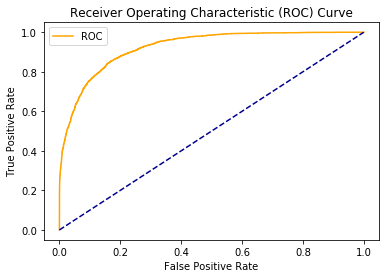

AUC for gradient boosting: 0.92
F1 score for gradient boosting: 0.71


In [23]:
#Performance metrics
probs_gb = gb.predict_proba(X_val)  
probs_gb = probs_gb[:, 1]  
fper, tper, thresholds = roc_curve(Y_val, probs_gb) 
plot_roc_curve(fper, tper)
auc_gb = roc_auc_score(Y_val, probs_gb)
print('AUC for gradient boosting: %.2f' % auc_gb)
y_pred = gb.predict(X_val)
f1_gb = f1_score(y_pred, Y_val)
print('F1 score for gradient boosting: %.2f' % f1_gb)

In [24]:
# Confusion matrix for gradient boosting
predictions = gb.predict(X_val)

print("Confusion Matrix:")
print(confusion_matrix(Y_val, predictions))

print("Classification Report")
print(classification_report(Y_val, predictions))

Confusion Matrix:
[[6953  464]
 [ 794 1558]]
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7417
           1       0.77      0.66      0.71      2352

    accuracy                           0.87      9769
   macro avg       0.83      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769



### Model - 6 : Naive Bayes

In [25]:
#Applying model with default parameters
nb = GaussianNB()
nb.fit(X_train, Y_train)

print('Accuracy of Naive Bayes Classifier on training set: {:.2f}'
     .format(nb.score(X_train, Y_train)))
print('Accuracy of Naive Bayes Classifier on validation set: {:.2f}'
     .format(nb.score(X_val, Y_val)))

Accuracy of Naive Bayes Classifier on training set: 0.80
Accuracy of Naive Bayes Classifier on validation set: 0.79


In [26]:
nb_acc = round((nb.score(X_val, Y_val)),2)
print(nb_acc)

0.79


In [27]:
#performance metrics
probs_nb = nb.predict_proba(X_val)  
probs_nb = probs_nb[:, 1]  
fper, tper, thresholds = roc_curve(Y_val, probs_nb) 
#plot_roc_curve(fper, tper)
auc_nb = roc_auc_score(Y_val, probs_nb)
print('AUC for naive bayes: %.2f' % auc_nb)
y_pred = nb.predict(X_val)
f1_nb = f1_score(y_pred, Y_val)
print('F1 score for naive bayes: %.2f' % f1_nb)

AUC for naive bayes: 0.84
F1 score for naive bayes: 0.41


### Model - 7 :  Xgboost

In [ ]:
#Hyperparameter tuning
n_estimators = [100,200,400,600]
max_depth = [2, 4, 6, 8]
param_grid = dict(n_estimators=n_estimators,max_depth=max_depth)
#kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(XGBClassifier(), param_grid, scoring="neg_log_loss", n_jobs=-1)
grid_result = grid_search.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

In [28]:
#Applying best model
xgb=XGBClassifier(max_depth=6,n_estimators=200)
xgb.fit(X_train,Y_train)
print('Accuracy of XGB Classifier on training set: {:.2f}'
     .format(xgb.score(X_train, Y_train)))
print('Accuracy of XGB Classifier on validation set: {:.2f}'
     .format(xgb.score(X_val, Y_val)))

Accuracy of XGB Classifier on training set: 0.90
Accuracy of XGB Classifier on validation set: 0.87


In [29]:
xgb_acc = round((xgb.score(X_val, Y_val)),2)
print(xgb_acc)

0.87


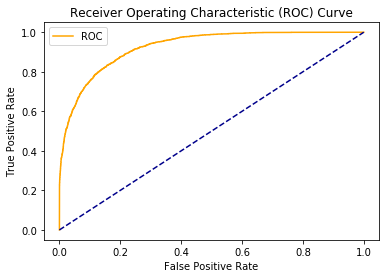

AUC for xgboost: 0.93
F1 score for xgboost: 0.71


In [30]:
#Performance metrics
probs_xgb = xgb.predict_proba(X_val)  
probs_xgb = probs_xgb[:, 1]  
fper, tper, thresholds = roc_curve(Y_val, probs_xgb) 
plot_roc_curve(fper, tper)
auc_xgb = roc_auc_score(Y_val, probs_xgb)
print('AUC for xgboost: %.2f' % auc_xgb)
y_pred = xgb.predict(X_val)
f1_xgb = f1_score(y_pred, Y_val)
print('F1 score for xgboost: %.2f' % f1_xgb)

In [31]:
#Confusion matrix for xgboost
predictions = xgb.predict(X_val)

print("Confusion Matrix:")
print(confusion_matrix(Y_val, predictions))

print("Classification Report")
print(classification_report(Y_val, predictions))

Confusion Matrix:
[[6975  442]
 [ 799 1553]]
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7417
           1       0.78      0.66      0.71      2352

    accuracy                           0.87      9769
   macro avg       0.84      0.80      0.82      9769
weighted avg       0.87      0.87      0.87      9769



# 4. Trying upsampling minority class

In [ ]:
Y_train.value_counts()

As we can see the minority class (>50K) has about only 1/3rd observations in the data. We try raising the number of observations of minority class to about 40% of the entire dataset using SMOTE sampling

In [ ]:
smt = SMOTE(sampling_strategy=0.4)
X2_train, Y2_train = smt.fit_sample(X_train, Y_train)
np.bincount(Y2_train)

## 4.1. Applying xgboost to new upsampled dataset

In [ ]:
xgb2=XGBClassifier(max_depth=6,n_estimators=200)
xgb2.fit(X2_train,Y2_train)
print('Accuracy of XGB Classifier on training set: {:.2f}'
     .format(xgb2.score(X2_train, Y2_train)))
print('Accuracy of XGB Classifier on validation set: {:.2f}'
     .format(xgb2.score(X_val, Y_val)))

In [ ]:
probs = xgb2.predict_proba(X_val)  
probs = probs[:, 1]  
fper, tper, thresholds = roc_curve(Y_val, probs) 
plot_roc_curve(fper, tper)
auc_xgb2 = roc_auc_score(Y_val, probs)
print('AUC for xgboost on upsampled data: %.2f' % auc_xgb2)
y_pred = xgb2.predict(X_val)
f1_xgb2 = f1_score(y_pred, Y_val)
print('F1 score for xgboost on upsampled data: %.2f' % f1_xgb2)

## 4.2. Applying random forest on up-sampled data

In [ ]:
rf2 = RandomForestClassifier(n_estimators = 50)
rf2.fit(X2_train, Y2_train)

print('Accuracy of Random Forest classifier on training set: {:.2f}'
     .format(rf2.score(X2_train, Y2_train)))
print('Accuracy of Random Forest classifier on validation set: {:.2f}'
     .format(rf2.score(X_val, Y_val)))

In [ ]:
probs = rf2.predict_proba(X_val)  
probs = probs[:, 1]  
fper, tper, thresholds = roc_curve(Y_val, probs) 
plot_roc_curve(fper, tper)
auc_rf2 = roc_auc_score(Y_val, probs)
print('AUC for random forests on upsampled data: %.2f' % auc_rf2)
y_pred = rf2.predict(X_val)
f1_rf2 = f1_score(y_pred, Y_val)
print('F1 score for random forests on upsampled data: %.2f' % f1_rf2)

Upsampling the minority class has not improved the model performance significantly. So we proceed to compare models without upsampling.

# 5. Best model

### Xgboost/Gradient boosting

In [32]:
models = pd.DataFrame({
    'Model': ['Support Vector Classifier', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Gradient Boosting','Extreme Gradient Boosting' 
              ],
    'Validation Accuracy': [svm_acc, knn_acc, lr_acc, 
              rf_acc, nb_acc, gb_acc, 
              xgb_acc],
    'AUC': [auc_svm,auc_knn,auc_lr,auc_rf,auc_nb,auc_gb,auc_xgb],
    'F1 Score': [f1_svm,f1_knn,f1_lr,f1_rf,f1_nb,f1_gb,f1_xgb]})
models.sort_values(by='AUC', ascending=False)



,Model,Validation Accuracy,AUC,F1 Score
6,Extreme Gradient Boosting,0.87,0.925803,0.714516
5,Gradient Boosting,0.87,0.924101,0.712391
3,Random Forest,0.85,0.898939,0.671879
4,Naive Bayes,0.79,0.835515,0.411023
1,KNN,0.78,0.665746,0.397026
0,Support Vector Classifier,0.80,0.638439,0.311003
2,Logistic Regression,0.80,0.570070,0.377193


Extreme gradient boosting yields the best performance in terms of AUROC and F1 score as well as accuracy on the validation set.

We choose xgboost as the best model.

# 6. Ensemble model

We try making an ensemble model to see if it improves our prediction accuracy.

We make an ensemble model of 4 models: naive bayes, random forests, xgboost and KNN
    
Soft voting is used to form the ensemble model

In [ ]:
from sklearn.ensemble import VotingClassifier
model_s = VotingClassifier(estimators=[('nb', nb),('rf',rf),('xgb',xgb),('knn',knn)], voting='soft')
model_s.fit(X_train,Y_train)
model_s.score(X_val,Y_val)

In [ ]:
probs = model_s.predict_proba(X_val)  
probs = probs[:, 1]  
fper, tper, thresholds = roc_curve(Y_val, probs) 
plot_roc_curve(fper, tper)
auc_rf2 = roc_auc_score(Y_val, probs)
print('AUC for ensemble model: %.2f' % auc_rf2)
y_pred = model_s.predict(X_val)
f1_rf2 = f1_score(y_pred, Y_val)
print('F1 score for ensemble model: %.2f' % f1_rf2)

Using an ensemble model has not improved but reduced the model performance, hence, we proceed with xgboost as the best model and use it for predicting on the test dataset

# 7. Predicting on Test dataset

Preparing test data:
    
Encoding the output variable(class) as 0 and 1
Converting variables into appropriate data types
Imputing null values
One-hot encoding categorical variables

In [33]:
test = test.sample(frac=1).reset_index(drop=True)
test['income'] = 0
test['income'][test['class'] == ' <=50K.'] = 0
test['income'][test['class'] == ' >50K.'] = 1

In [ ]:
#test.head()

In [34]:
test = test.drop(['class'],axis = 1)
test[['workclass', 'education','marital-status','occupation','relationship','race','sex','native-country']] = test[['workclass', 'education','marital-status','occupation','relationship','race','sex','native-country']].astype('category') 
test.replace(' ?', np.nan, inplace= True)
test['workclass'] = test['workclass'].cat.add_categories('None')
test['workclass'].fillna('None', inplace =True) 
test['occupation'] = test['occupation'].cat.add_categories('Unemployed')
test['occupation'].fillna('Unemployed', inplace =True) 
test['native-country'] = test['native-country'].cat.add_categories('Unknown')
test['native-country'].fillna('Unknown', inplace =True)
X_test = test.loc[:, test.columns != 'income']
Y_test = test['income']
Y_test = Y_test.astype('category')
label = LabelEncoder()
X_test = X_test.drop(columns = ['native-country'],axis = 1)
X_enc = X_test.select_dtypes(include = ['category'])
X_enc = pd.get_dummies(X_enc,columns = ['workclass','education','marital-status','occupation','relationship',
                                       'race','sex'])
X_copy = X_test.drop(columns = ['workclass','education','marital-status','occupation','relationship',
                                       'race','sex'],axis = 1)
X_enc = X_enc.apply(label.fit_transform)
X_test = pd.concat([X_copy,X_enc],axis = 1)

## 7.1. Applying Xgboost on test data set

In [35]:
print('Accuracy of XGB Classifier on test dataset: {:.2f}'
     .format(xgb.score(X_test, Y_test)))

Accuracy of XGB Classifier on test dataset: 0.87


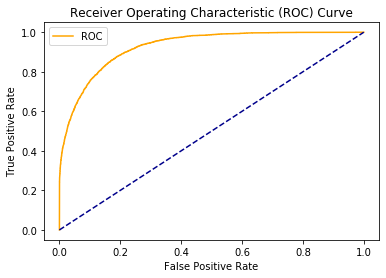

AUC for xgboost on test dataset: 0.93
F1 score for xgboost on test dataset: 0.70


In [36]:
probs_xgb_test = xgb.predict_proba(X_test)  
probs_xgb_test = probs_xgb_test[:, 1]  
fper, tper, thresholds = roc_curve(Y_test, probs_xgb_test) 
plot_roc_curve(fper, tper)
auc_xgb_test = roc_auc_score(Y_test, probs_xgb_test)
print('AUC for xgboost on test dataset: %.2f' % auc_xgb_test)
y_pred = xgb.predict(X_test)
f1_xgb_test = f1_score(y_pred, Y_test)
print('F1 score for xgboost on test dataset: %.2f' % f1_xgb_test)

In [37]:
#Confusion matrix
predictions = xgb.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(Y_test, predictions))

print("Classification Report")
print(classification_report(Y_test, predictions))

Confusion Matrix:
[[11705   730]
 [ 1363  2483]]
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     12435
           1       0.77      0.65      0.70      3846

    accuracy                           0.87     16281
   macro avg       0.83      0.79      0.81     16281
weighted avg       0.87      0.87      0.87     16281



The model performs quite well with an AUROC score of 0.93 and a F1 score of 0.71

For class '>50K' the precision and recall are lesser than that of '<=50K'. This maybe due to class imbalance in the dataset.

# 8. Important variables

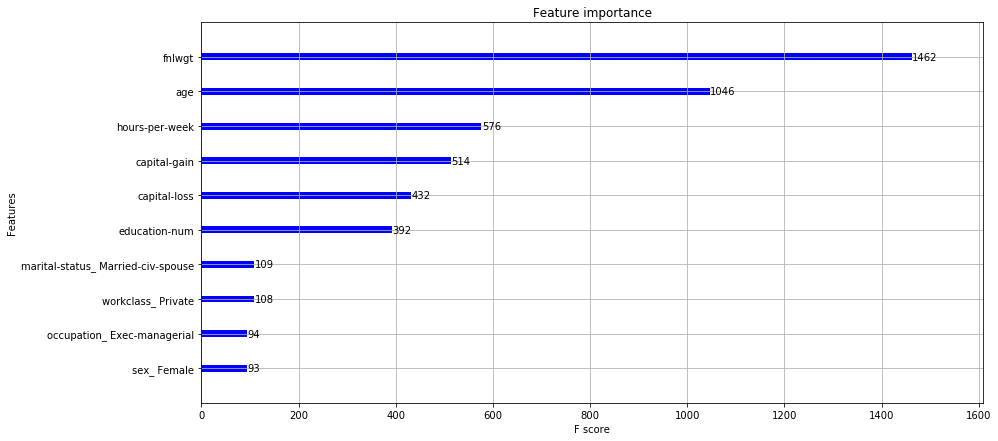

In [38]:
from xgboost import plot_importance
plt.rcParams["figure.figsize"] = (14, 7)
plot_importance(xgb,max_num_features=10, color='blue') 

### The most important varibles in predicting the income class are:

(1) fnlwgt
(2) Age 
(3) Hours per week
(4) Capital gain
(5) Capital loss
(6) Education number/education
(7) Marital status
(8) Workclass

While description of 'fnlwgt' is not available, it remains the variable which carries the most information for predicting the income class of a person. 'Age' was expected to be important as age determines a lot of other factors like education, capital gain, capital loss and also martial-status and workclass to some extent.

Capital gain and capital loss directly affect the income of a person and are rightfully regarded important by our model.

Education of a person also is highly vital in deciding the income class of a person. As we saw from the eda plots above, a person with only a high-school degree is highly likely to earn less than 50K and one with a bachelors degree earns more than 50K most of the times.

Inclusion of Marital-status and Workclass was expected because in both the income classes, each of these variables has a category which has the maximum obeservations which might help our model in predicting the income class of a person. 


